In [4]:
# Things for data handling class to manage: 
#    Duplicate datetimes...when there is 15min data this always going to happen.  If it's not 15min data, remove 
# duplicates (df[~df.duplicated('Date')]), and if it is 15min data, calculate daily means: daily_means = df.resample('D').mean()
#    Check to see if there are column names and if not, maybe insert some?
#    In import method, if there no column names are provided, search for keywords for date (ex. date, datetime, etc.) and if none 
#    can be found, set date to first column as default and value to the second column.  


#Other things to do:
# Create option to change y axis label
# add setter to df to do error handle df and ALSO to handle dfs or csvs
# create more functions to clean up code
# clean up legend
# handle colors differently. Don't hard code them in a self variable and create an if statement in case the num of highlighted yrs is > num of colors in colors list.

-------This module creates customized StackedLinePlots.


In [1]:
import requests 
import pandas as pd
def get_USGS_data(file_format='json', sites='09380000', start_date='2010-10-01', end_date='2023-10-01', site_status='all'):
    server = 'https://waterservices.usgs.gov'
    endpoint = '/nwis/dv'
    file_format = f'/?format={file_format}'
    sites = f'&sites={sites}'
    start_date = f'&startDT={start_date}'
    end_date = f'&endDT={end_date}'
    site_status = f'&siteStatus={site_status}'
    
    url = f'{server}{endpoint}{file_format}{sites}{start_date}{end_date}{site_status}'
    print(url)
    req = requests.get(url)
        #Correct url for reference:
        #'https://waterservices.usgs.gov/nwis/dv/?format=json&sites=09380000&startDT=1921-10-01&endDT=2023-10-01&siteStatus=all'
    
    if req.ok:
        df = pd.DataFrame.from_dict(pd.DataFrame(req.json()['value']['timeSeries'][0]['values'][0]['value']))
        # df.set_index('dateTime', inplace=True)
        return req, df
        

In [88]:
req, df = get_USGS_data(sites='09380000', start_date='1921-10-01', end_date='2023-10-01')

https://waterservices.usgs.gov/nwis/dv/?format=json&sites=09380000&startDT=1921-10-01&endDT=2023-10-01&siteStatus=all


In [89]:
df.to_csv("leesferry_webservice.csv")

In [13]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is F489-3F0A

 Directory of C:\Users\Local User\Projects\StackedLinePlots

11/27/2023  12:12 PM    <DIR>          .
11/27/2023  12:12 PM    <DIR>          ..
11/27/2023  11:58 AM    <DIR>          .ipynb_checkpoints
11/22/2023  07:27 PM                 0 Analysis.py
11/27/2023  12:05 PM        11,503,157 LeesFerry.csv
11/22/2023  07:24 PM            11,021 StackedLinePlots.py
11/22/2023  07:24 PM            10,328 StackedLinePlots_original.py
11/27/2023  11:52 AM           103,889 Untitled.ipynb
11/27/2023  12:12 PM            19,537 Untitled1.ipynb
               6 File(s)     11,647,932 bytes
               3 Dir(s)  301,230,157,824 bytes free


In [3]:
LeesFerry2 = StackedLinePlot(csv_path="leesferry_webservice.csv", name_of_date_column='dateTime', name_of_Q_column='value')

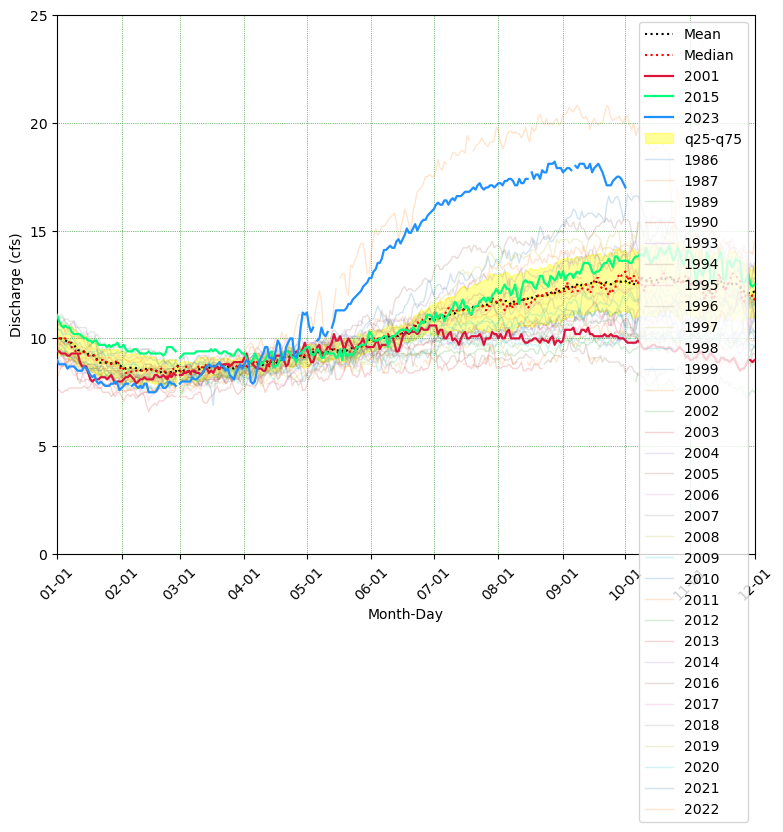

In [4]:
LeesFerry2.calculate_statistics()
LeesFerry2.plotStackedLinePlot(
                             # forced_x_positions=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 336],
                             # forced_x_labels=['01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01', '10-01', '11-01', '12-01'],
                             title=None,
                             highlight_years=[2001, 2015, 2023],
                             plot_central_tendency_stats=True,
                             quartile_shading=True,
                             quartile_shading_alpha=0.4,
                             quartile_shading_zorder=1,
                             series_labels=True,
                             series_alpha=.2,
                             group_by_decade=False,
                             decade_stats_to_plot="All",
                             y_lower_lim=0,
                             y_upper_lim=25,
                             # legend='upper right',
                             legend_ncol=1,
                             input_start_year=2010,
                             input_end_year=2020
)

In [67]:
# LeesFerry = StackedLinePlot(csv_path="LeesFerry.csv", name_of_date_column='dateTime', name_of_Q_column='value')

In [69]:
# df = pd.read_csv('LeesFerry.csv')

In [66]:
# df

In [68]:
# df[df.duplicated('dateTime')]

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import calendar
# from scipy.integrate import trapz
from collections import OrderedDict

class StackedLinePlot:
    def __init__(self, csv_path, name_of_date_column, name_of_Q_column):
        self.csv_path = csv_path
        self._name_of_date_column = name_of_date_column
        self._name_of_Q_column = name_of_Q_column
        self.df = csv_path
        self._df = self.df
        self._df_stat_summary = self._df.describe()
        self._df['Date'] = pd.to_datetime(self._df[name_of_date_column])
        self._df = self._df[~self._df.duplicated('Date')]
        self._df['month'] = self._df['Date'].dt.month
        self._df['Year'] = self._df['Date'].dt.year
        self._df['month-day'] = self._df['Date'].apply(lambda x: x.strftime('%m-%d'))
        self._pivot_table = self._df.pivot(index="month-day", columns='Year', values=name_of_Q_column)
        self._pivot_table_monthly = self._df.pivot(columns='month', values=name_of_Q_column)
        self._pivot_table_yearly_stats = {year: self._pivot_table.iloc[:, i].describe() for i, year in enumerate(self._pivot_table.columns)}
        self._forced_x_positions = None
        self._forced_x_labels = None
        self._mean = None
        self._median = None
        self._st_dev = None
        self._lower_bound = None
        self._upper_bound = None
        self._lower_bound_percentile25 = None
        self._upper_bound_percentile75 = None
        self._colors = ['crimson', 'springgreen', 'dodgerblue', 'purple', 'green', 'deeppink', "lawngreen", "coral", "lime", "navy", "goldenrod"]
        # self._ylim_max = self.df[name_of_Q_column].max() + self.df[name_of_Q_column].max() * 0.05
        # print(self._ylim_max)
    @property
    def df(self):
        return self._df

    @df.setter
    def df(self, cvs_path):
        try:
            self._df = pd.read_csv(cvs_path)
        except Exception as e:
            print(e)

    

    @property
    def MeanValue(self):
        if self._mean_value is None:
            self.calculate_statistics()
        return self._mean_value

    @property
    def MonthlyStats(self):
        monthly_stats = self._monthly_stats
        monthly_stats.index = monthly_stats.index.map(lambda x: calendar.month_name[x])
        monthly_stats = monthly_stats.round(1)
        return monthly_stats

    @property
    def Stats(self):
        return self._df_stat_summary.round(2)

    def calculate_statistics(self):
        self._stats = self._df.groupby("month-day")[self._name_of_Q_column].agg(['mean', 'median', 'std', ("q25", lambda x: x.quantile(0.25)), ("q75", lambda y: y.quantile(0.75))])
        self._monthly_stats = self._df.groupby("month")[self._name_of_Q_column].agg(['mean', 'median', 'std', ("q25", lambda x: x.quantile(0.25)), ("q75", lambda y: y.quantile(0.75))])
        self._mean = self._stats.iloc[:, 0]
        self._median = self._stats.iloc[:, 1]
        self._st_dev = self._stats.iloc[:, 2]
        self._percentile25 = self._stats.iloc[:, 3]
        self._percentile75 = self._stats.iloc[:, 4]
        self._lower_bound_st_dev = self._mean - self._st_dev
        self._upper_bound_st_dev = self._mean + self._st_dev
        self._lower_bound_percentile25 = self._mean - self._percentile25
        self._upper_bound_percentile75 = self._mean + self._percentile75

    # def calculate_yearly_volumes(self):
    #     years = []
    #     area = []
    #     for year in self._pivot_table.columns:
    #         dates = list(range(0, len(self._pivot_table[year].dropna())))
    #         area.append(trapz(self._pivot_table[year].dropna(), dates))
    #         years.append(year)

    #     Area_dict = OrderedDict()
    #     for key, value in zip(years, area):
    #         Area_dict[key] = value
    #     return Area_dict

    def plotStackedLinePlot(self,
                             forced_x_positions=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 336],
                             forced_x_labels=['01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01', '10-01', '11-01', '12-01'],
                             title=None,
                             highlight_years=[2001, 2015, 2023],
                             plot_central_tendency_stats=True,
                             quartile_shading=True,
                             quartile_shading_alpha=0.4,
                             quartile_shading_zorder=1,
                             series_labels=True,
                             series_alpha=1,
                             group_by_decade=False,
                             decade_stats_to_plot="All",
                             y_lower_lim=0,
                             y_upper_lim=25,
                             legend='upper right',
                             legend_ncol=1,
                             input_start_year=2010,
                             input_end_year=2020,
                             ylabel="Discharge (cfs)"
                           ):

        # if y_upper_lim == "Auto":
        #     y_upper_lim = self._ylim_max
        #     print(y_upper_lim)
        self._df = self._df[(self._df['Year'] >= input_start_year) & (self._df['Year'] <= input_end_year)]
        self._unique_years = list(self._df['Year'].unique())
        self._start_year = self._unique_years[0]
        self._end_year = self._unique_years[-1]
        self._num_of_decades = math.ceil((self._end_year - self._start_year) / 10)
        self._unique_decades = list(self._df['Year'].apply(lambda year: (year // 10) * 10).unique())
        self._forced_x_positions = forced_x_positions
        self._forced_x_labels = forced_x_labels
        self.input_start_year = input_start_year
        self.input_end_year = input_end_year

        self.calculate_statistics()

        fig, ax = plt.subplots(figsize=(9, 7))

        if plot_central_tendency_stats == True:
            self._mean.plot(ax=ax, label="Mean", linestyle=':', color='black', linewidth=1.5, zorder=3)
            self._median.plot(ax=ax, label="Median", linestyle=':', color='red', linewidth=1.5, zorder=3)
        else:
            pass

        if highlight_years:
            for i, year in enumerate(highlight_years):
                self._pivot_table.loc[:, year].plot(ax=ax, linewidth=1.6, zorder=3,
                color=self._colors[i])

        else:
            pass

        if quartile_shading == True:
            plt.fill_between(
                list(range(0, len(pd.DataFrame(self._mean).iloc[:, 0]))),
                pd.DataFrame(self._mean).iloc[:, 0].astype(float),
                pd.DataFrame(self._lower_bound_st_dev).iloc[:, 0].astype(float),
                where=(pd.DataFrame(self._mean).iloc[:, 0].astype(float) > pd.DataFrame(self._lower_bound_percentile25).iloc[:, 0].astype(float)),
                interpolate=True, color='yellow', alpha=quartile_shading_alpha, zorder=quartile_shading_zorder, label="q25-q75")

            plt.fill_between(
                list(range(0, len(pd.DataFrame(self._mean).iloc[:, 0]))),
                pd.DataFrame(self._mean).iloc[:, 0].astype(float),
                pd.DataFrame(self._upper_bound_st_dev).iloc[:, 0].astype(float),
                where=(pd.DataFrame(self._mean).iloc[:, 0].astype(float) < pd.DataFrame(self._upper_bound_percentile75).iloc[:, 0].astype(float)),
                interpolate=True, color='yellow', alpha=quartile_shading_alpha, zorder=1)

        if group_by_decade == True:
            decade_groups = []

            for i in self._unique_decades:
                decade_groups.append(list(range(i, i + 10)))

            if len(decade_groups) == 1:
                start_year_index = decade_groups[0].index(self.input_start_year)
                end_year_index = decade_groups[0].index(self.input_end_year)
                decade_groups[0] = decade_groups[0][start_year_index:end_year_index + 1]

            else:
                start_year_index = decade_groups[0].index(self.input_start_year)
                decade_groups[0] = decade_groups[0][start_year_index:]
                end_group = list(range(decade_groups[-1][0], self.input_end_year + 1))
                decade_groups[-1] = end_group

            colors = ['blue', 'orange', 'purple', 'red']
            for i, decade in enumerate(decade_groups):
                decadeDF = self._pivot_table.loc[:, decade]
                means = decadeDF[decadeDF.columns].mean(axis=1)
                medians = decadeDF[decadeDF.columns].median(axis=1)
                if decade_stats_to_plot == 'mean':
                    means.plot(ax=ax, linestyle="--", label="mean {} - {}".format(decade[0], decade[-1]), linewidth=1, color=colors[i])
                elif decade_stats_to_plot == 'median':
                    medians.plot(ax=ax, linestyle="-.", label="median {} - {}".format(decade[0], decade[-1]), linewidth=1, color=colors[i])
                else:
                    means.plot(ax=ax, linestyle="--", label="mean {} - {}".format(decade[0], decade[-1]), linewidth=1, color=colors[i])
                    medians.plot(ax=ax, linestyle="-.", label="median {} - {}".format(decade[0], decade[-1]), linewidth=1, color=colors[i])

        else:
            if highlight_years:
                filtered_years = [year for year in self._pivot_table.columns if year not in highlight_years]
                filtered_pivot_table = self._pivot_table.loc[:, filtered_years]
            else:
                filtered_pivot_table = self._pivot_table

            if series_labels == False:
                for i in filtered_pivot_table.columns:
                    filtered_pivot_table[i].plot(ax=ax, alpha=series_alpha, zorder=2, linewidth=1.0, label='')
            else:
                filtered_pivot_table.plot(ax=ax, alpha=series_alpha, zorder=2, linewidth=1.0, label='')

        if self._forced_x_positions is not None and self._forced_x_labels is not None:
            ax.set_xticks(self._forced_x_positions)
            xlim_min = self._forced_x_positions[0]
            xlim_max = self._forced_x_positions[-1]
            ax.set_xticklabels(self._forced_x_labels, rotation=45)
            ax.set_xlim([xlim_min, xlim_max])
            ax.set_ylim([y_lower_lim, y_upper_lim])

        plt.grid(color='green', linestyle=":", linewidth=0.5)
        plt.xlabel('Month-Day')
        plt.ylabel(ylabel)
        plt.title(title)

        if legend == "partial":
            plt.legend(loc='upper right', ncol=legend_ncol, labels=['Mean', 'Median'])

        else:
            plt.legend(loc=legend, ncol=legend_ncol)

        plt.show()

if __name__ == "__main__":
    print("-------This module creates customized StackedLinePlots.-------")


-------This module creates customized StackedLinePlots.-------
